# Feature Importance for PTB

### Caizhi Huang, Craig Gin and Ben Callahan

## Set up

In [1]:
import pickle
import shap

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [2]:
plot_params = {'figure.titlesize': 24,  # Title font size
               'axes.labelsize': 16,  # Axes tick labels font size
               'axes.titlesize': 16,  # Axes figure label font size
               'legend.fontsize': 16,  # Legend text font size
               'xtick.labelsize': 16,  # X axis tick labels font size
               'ytick.labelsize': 16,  # Y axis tick labels font size
               'lines.linewidth': 1.5, # Width of lines on plots
              }

plt.rcParams.update(plot_params)

## Load data

In [3]:
data_file = "importance_results_prop.pkl"

with open(data_file, 'rb') as f:
    importance_dict = pickle.load(f)

In [4]:
data_file = 'data/genus_data.pkl'

with open(data_file, 'rb') as f:
    genus_data = pickle.load(f)

In [5]:
prop_data = genus_data['trans']['prop']
meta_data = genus_data['meta']

In [6]:
# List of studies in order to be plotted
study_list = ['Br', 'Fe', 'Ki', 'Ro', 'St', 'Di',
              'El', 'Bl', 'SC', 'Su', 'Ta', 'UC']

## Feature Importance Ranking by Study

In [7]:
# Find top n most important features and return them in descending order
def top_n(shap_mat, n=10):
    mean_shap = np.mean(np.abs(shap_mat), axis=0)
    descending_shap = np.argsort(mean_shap)[:-(n+1):-1]
    return descending_shap

In [8]:
# Create a dictionary that has the features in order of importance by study
importance_rank = {}

for study in study_list:
    n_repetitions = len(importance_dict[study])
    shap_values_val_list = [importance_dict[study][i]['shap_values_val'][1]
                             for i in range(n_repetitions)]
    shap_values_val = np.vstack(shap_values_val_list)
    X_train = prop_data[study]
    descending_shap = top_n(shap_values_val, n=X_train.shape[1])
    importance_rank[study] = list(X_train.columns[descending_shap])

In [9]:
# Create a data frame with feature ranking for each taxa/study
importance_by_taxa = {study: [importance_rank[study].index(taxa) + 1 for taxa in X_train.columns] 
                      for study in study_list}

importance_rank_df = pd.DataFrame(importance_by_taxa)
importance_rank_df.index = X_train.columns

In [10]:
# Calculate mean rank for each taxa and add to data frame
importance_rank_df['mean'] = importance_rank_df.mean(axis=1)

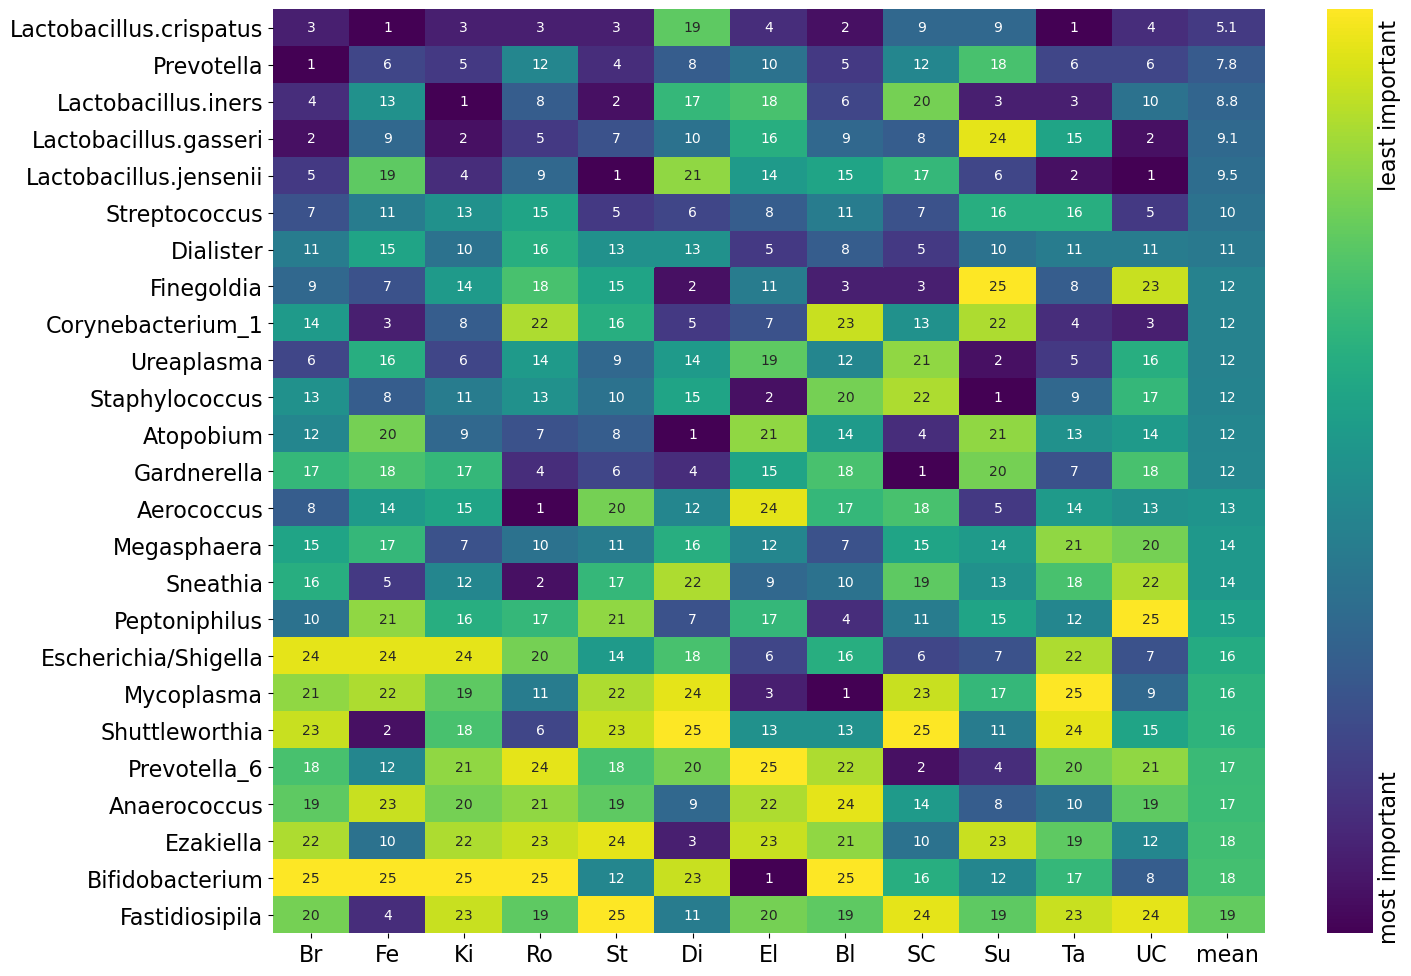

In [11]:
# Figure of feature importance ranks
fig = plt.figure(figsize=(16, 12))
ax = fig.add_subplot(111)
hm = sns.heatmap(importance_rank_df.sort_values('mean'), annot=True, ax=ax, cmap='viridis')

cbar = hm.collections[0].colorbar
cbar.set_ticks([5,  24.5])
cbar.ax.tick_params(size=0)
cbar.ax.set_yticklabels(['most important', 'least important'], rotation=90)

plt.show()

## SHAP summary plot for all studies

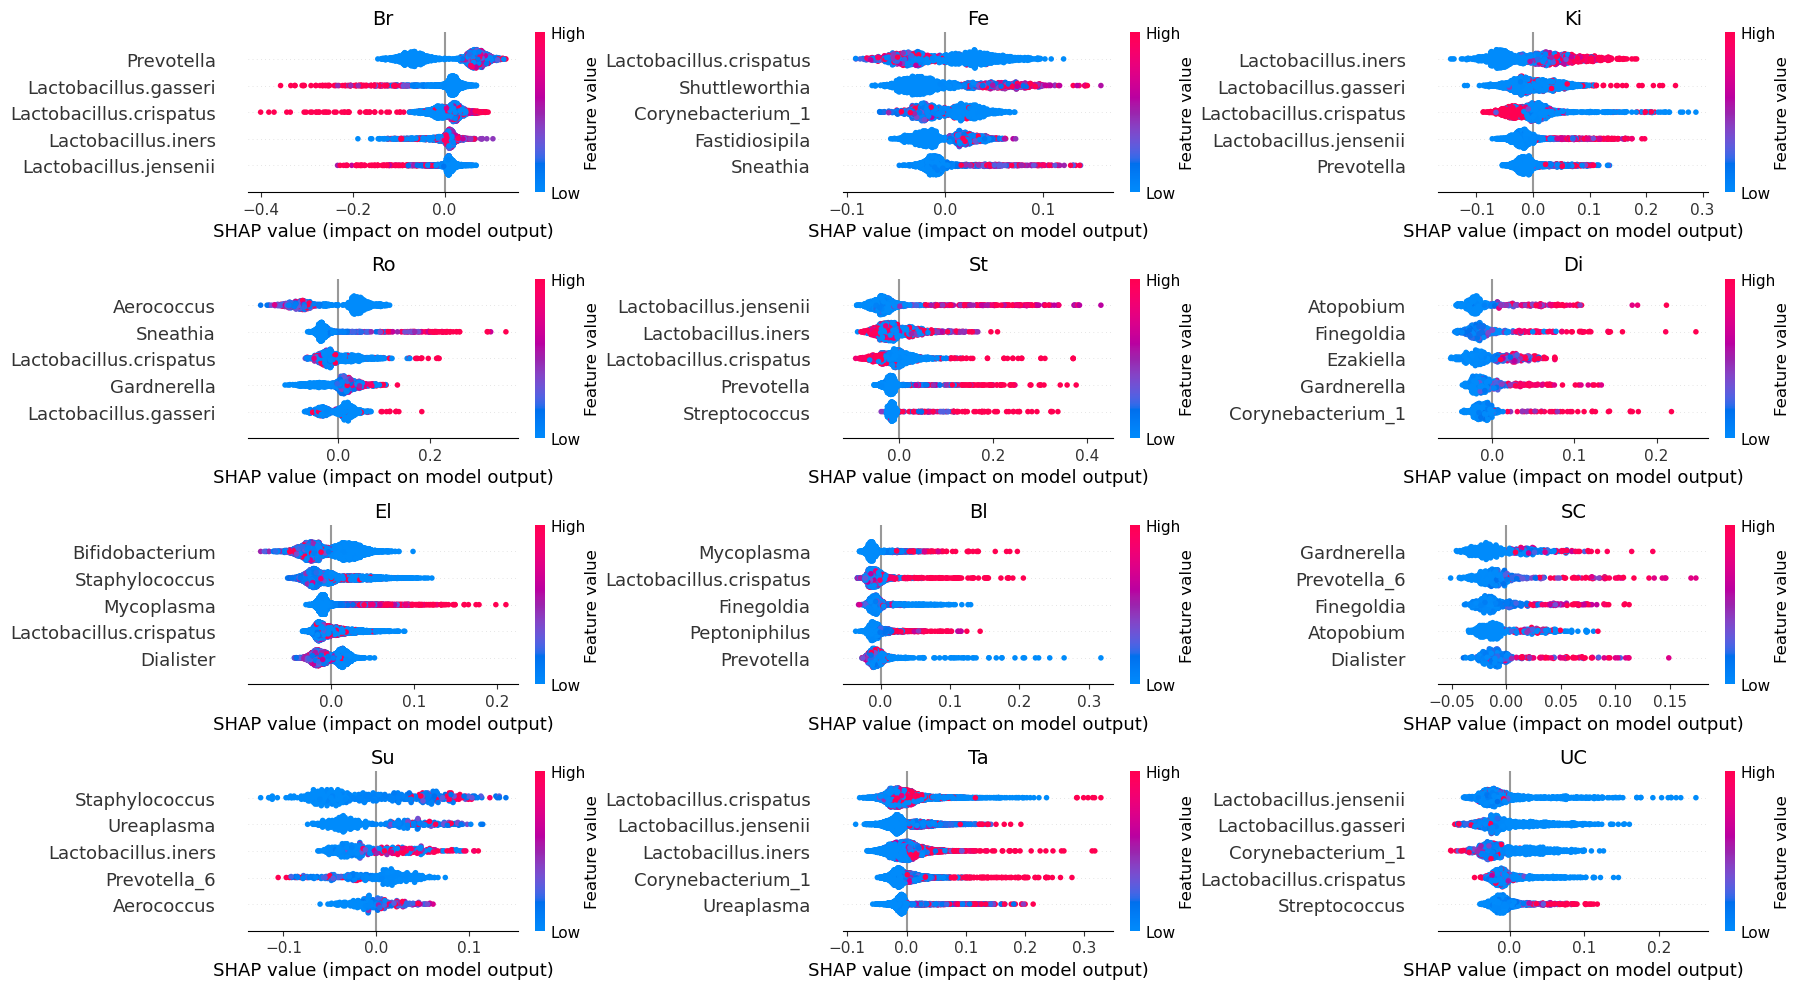

In [12]:
fig = plt.figure()

for study_ind, study in enumerate(study_list):

    n_repetitions = len(importance_dict[study])
    shap_values_val_list = [importance_dict[study][i]['shap_values_val'][1]
                              for i in range(n_repetitions)]
    shap_values_val = np.vstack(shap_values_val_list)
    
    X_val_list = [importance_dict[study][i]['X_val'] for i in range(n_repetitions)]
    X_val = pd.concat(X_val_list)
    
    y_val_list = [importance_dict[study][i]['y_val'] for i in range(n_repetitions)]
    y_val = pd.concat(y_val_list)

    ax = fig.add_subplot(4, 3, study_ind+1)

    shap.summary_plot(shap_values_val, X_val, show=False, max_display=5, plot_size=(18.0,10.0))

    ax.set_title('{}'.format(study), fontsize=14)
    
plt.tight_layout()    
plt.show()

## AUC with and without Aerococcus

In [13]:
# Load the results
AUC_compare = pd.read_csv('AUC_Aerococcus.csv', index_col=0)

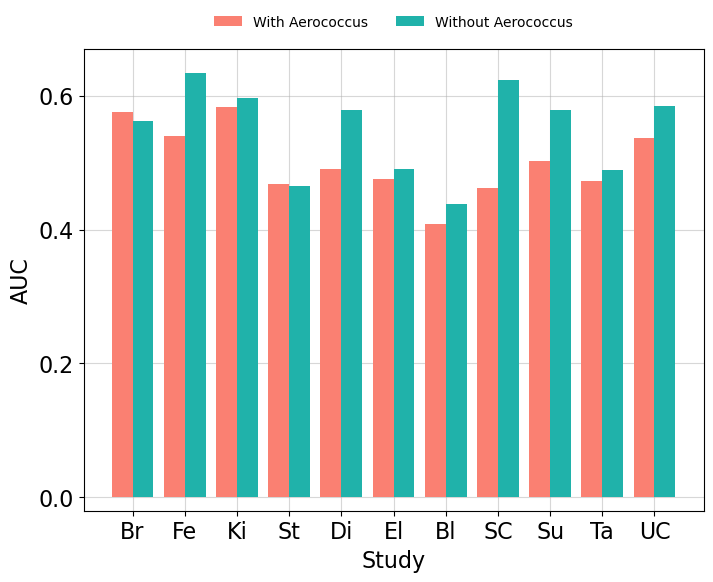

In [14]:
# Create the plot
x = np.arange(AUC_compare.shape[0])
width = 0.4

plt.figure(figsize=(8,6))
plt.grid(zorder=0, alpha=0.5)
plt.bar(x-width/2, AUC_compare['AUC_with_Aero'], width, color='salmon', label="With Aerococcus", zorder=3)
plt.bar(x+width/2, AUC_compare['AUC_without_Aero'], width, color='lightseagreen', label="Without Aerococcus", zorder=4)
plt.xticks(x, labels=[study for study in AUC_compare.index])
plt.yticks([0, 0.2, 0.4, 0.6])
plt.ylim([-0.02, 0.67])
plt.ylabel('AUC')
plt.xlabel('Study')

plt.legend(bbox_to_anchor=(0.5, 1.1), loc='upper center', ncol=2, fontsize=10, frameon=False)
plt.show()